In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm.auto import tqdm
from scipy.special import logit,expit

from src.IterativeFitting import IterativeFitting as IF
from src.HamMethods import ham_vanilla, ham_solved
from src.CorrFuncs import covariance_matrix, trend_est

In [464]:
# Setting seed
golden_seed = 6
seed = 8
np.random.seed(seed)

# Initializing simulation slope and intercept parameters
beta0 = -0.1
beta1 = 0.02
beta_age = 0.05
beta_income = -0.05
beta_sex = 1.0

# Number of samples
n = 40000

# Constructing covariate vectors for additional covariates to adjust
age_vector = np.random.uniform(low=0,high=1,size=n)
income_vector = np.random.uniform(low=0,high=1,size=n)
# sex_vector = np.random.binomial(n=1,p=0.6,size=n)

# Assigning exposure levels and getting relevant x's
exposure_levels = np.array([0.,1.,2.,3.])
xs = np.random.choice(exposure_levels,size = n)
sex_vector = np.random.binomial(n = 1,p = 0.1 + xs/4,size =n )


# Function to generate probabilities of being a case v non-case
other_covs = beta0 + (beta_age*age_vector) + (income_vector*beta_income) + (sex_vector*beta_sex) 
p = lambda x: (np.exp(beta1*x + other_covs))/(1 + np.exp(beta1*x + other_covs))

# Actually calculating probabilities on exposures as defined
px = p(xs)

# Actually assigning to case or not
outcomes = np.array([np.random.binomial(n=1,p=p,size=1)[0] for p in px])

# Constructing and sorting dataframe of outcomes and exposure
df = np.stack([outcomes,xs],axis=1)
# df = df[np.argsort(df[:, 1])]

# Getting xs corresponding to each exposure interval and corresponding case information
categories = [df[np.where(df[:,1] == i)[0]] for i in exposure_levels]
N = np.array([df.shape[0] for df in categories])
cases = np.array([np.sum(df[:,0]) for df in categories])
non_cases = N - cases
a_0, A = cases[0], cases[1:]
b_0, B = non_cases[0], non_cases[1:]
M = np.sum(cases)

# Getting crude estimates to compare
crude = lambda x,y: (x/y) / (a_0/b_0)
crudeors = crude(A,B)

# Constructing dummy variables with respect to exposure level
x = exposure_levels[1:]

to_adjust_df = pd.DataFrame({
    'age':age_vector,
    'income':income_vector,
    'sex':sex_vector,
    'exposure':xs.astype(int)
})
to_adjust_df['intercept']=1

to_adjust_df = pd.concat([to_adjust_df,pd.get_dummies(to_adjust_df['exposure'],prefix='exposure').astype(int).iloc[:,1:]],axis=1).drop('exposure',axis=1)

results = sm.Logit(endog=df[:,0], exog=to_adjust_df).fit()
true_C = results.cov_params().to_numpy()[4:,4:]
true_C_inv = np.linalg.inv(true_C)

# Get log-ORs and corresponding variances
L = results.params.to_numpy()[4:]
v = (results.bse.to_numpy()[4:])**2

Optimization terminated successfully.
         Current function value: 0.645992
         Iterations 5


In [465]:
np.exp(L)

array([0.99795593, 1.0243074 , 1.04804608])

In [466]:
crudeors

array([1.2551063 , 1.64324092, 2.17078667])

In [467]:
# Running GL
it_fit_ex = IF(L,A,N,M)
Ap, Bp, a0p, b0p = it_fit_ex.convexProgram()

C = covariance_matrix(Ap,Bp,a0p,b0p,v)
inv_C = np.linalg.inv(C)

In [468]:
# Recovering slope estimate for corrected correlation
vb_star = 1 / (x.T@inv_C@x)
b_star = vb_star*(x.T@inv_C@L)
b_star

0.016390360054777876

In [469]:
# Recovering standard slope estimate
vb = 1/(np.dot(x,np.dot(np.linalg.inv(np.diag(v)),x)))
b = vb*(np.dot(x,np.dot(np.linalg.inv(np.diag(v)),L)))
b

0.01281627465337195

In [470]:
rootWols = np.diag(1/np.sqrt(v))
X_intercept_ols = np.vstack([np.ones(len(x)),x]).T
intercept_ols_slope = np.linalg.lstsq(rootWols@X_intercept_ols,rootWols@L,rcond = 1e-15)[0][1]
intercept_ols_slope

0.024585115874140674

In [471]:
# Getting Oracle estimates
vb_oracle = 1/(np.dot(x,np.dot(true_C_inv,x)))
b_oracle = vb_oracle*(np.dot(x,np.dot(true_C_inv,L)))
b_oracle

0.01633161515485301

In [472]:
# Getting estimates from covariance matrix generated from raw counts
C_raw = covariance_matrix(A,B,a_0,b_0,v)
inv_C_raw = np.linalg.inv(C_raw)

vb_r = 1/(x.T@inv_C_raw@x)
b_r = vb_r*(x.T@inv_C_raw@L)
b_r

0.016216320901233153

In [473]:
x_valsp = np.hstack([0,x])
plt.scatter(x,L,alpha=0.5,c="rebeccapurple",s=100)
plt.scatter(0,0,s=50,c="forestgreen")
plt.plot(x_valsp,b_star*x_valsp,label = 'GL',linestyle = 'dashed')
plt.plot(x_valsp,b_oracle*x_valsp,label = 'Oracle_Cov', alpha = 0.5,lw = 5)
plt.plot(x_valsp,beta1*x_valsp,label = 'Truth',c="cornflowerblue",linestyle="dashdot")
plt.plot(x_valsp,b_r*x_valsp,label="Crude",c="maroon",lw = 5,alpha = 0.5)
plt.plot(x_valsp,intercept_ols_slope*x_valsp,label="Intercept",c="lightsteelblue")
plt.plot(x_valsp,b*x_valsp,label = "OLS")
plt.legend()

In [31]:
GL_pe_list = []
GL_v_list = []
oracle_pe_list = []
oracle_v_list = []
OLS_pe_list = []
OLS_v_list = []
crude_pe_list = []
crude_v_list = []
hamling_pe_list = []
hamling_v_list = []

crude_cov = []
gl_cov = []
ham_cov = []
oracle_cov = []

# Setting seed
golden_seed = 6
seed = 8
np.random.seed(seed)

# Initializing simulation slope and intercept parameters
beta0 = -0.1
beta1 = 0.02
beta_age = 1.
beta_income = -0.05
beta_sex = 5.0

# Number of samples
n = 10000

# Simulation number
sim_no = 500

for i in tqdm(range(sim_no)):
    # Constructing covariate vectors for additional covariates to adjust
    age_vector = np.random.uniform(low=0,high=1,size=n)
    income_vector = np.random.uniform(low=0,high=1,size=n)
    # sex_vector = np.random.binomial(n=1,p=0.6,size=n)

    # Assigning exposure levels and getting relevant x's
    exposure_levels = np.array([0.,1.,2.,3.])
    xs = np.random.choice(exposure_levels,size = n,p = np.array([0.04,0.32,0.32,0.32]))
    sex_vector = np.random.binomial(n = 1,p = 0.1 + xs/4,size =n )


    # Function to generate probabilities of being a case v non-case
    other_covs = beta0 + (beta_age*age_vector) + (income_vector*beta_income) + (sex_vector*beta_sex) 
    #p = lambda x: (np.exp(beta1*x + other_covs))/(1 + np.exp(beta1*x + other_covs))
    px = (expit(beta1*xs+other_covs))

    # Actually calculating probabilities on exposures as defined
    #px = p(xs)

    # Actually assigning to case or not
    outcomes = np.array([np.random.binomial(n=1,p=p,size=1)[0] for p in px])

    # Constructing and sorting dataframe of outcomes and exposure
    df = np.stack([outcomes,xs],axis=1)
    # df = df[np.argsort(df[:, 1])]

    # Getting xs corresponding to each exposure interval and corresponding case information
    categories = [df[np.where(df[:,1] == i)[0]] for i in exposure_levels]
    N = np.array([df.shape[0] for df in categories])
    cases = np.array([np.sum(df[:,0]) for df in categories])
    non_cases = N - cases
    a_0, A = cases[0], cases[1:]
    b_0, B = non_cases[0], non_cases[1:]
    M = np.sum(cases)

    # Getting crude estimates to compare
    crude = lambda x,y: (x/y) / (a_0/b_0)
    crudeors = crude(A,B)

    # Constructing dummy variables with respect to exposure level
    x = exposure_levels[1:]

    to_adjust_df = pd.DataFrame({
        'age':age_vector,
        'income':income_vector,
        'sex':sex_vector,
        'exposure':xs.astype(int)
    })
    to_adjust_df['intercept']=1

    to_adjust_df = pd.concat([to_adjust_df,pd.get_dummies(to_adjust_df['exposure'],prefix='exposure').astype(int).iloc[:,1:]],axis=1).drop('exposure',axis=1)

    results = sm.Logit(endog=outcomes, exog=to_adjust_df).fit(disp=0)
    num_exposures = len(exposure_levels)-1
    true_C = results.cov_params().to_numpy()[-num_exposures:,-num_exposures:]
    true_C_inv = np.linalg.inv(true_C)

    # Get log-ORs and corresponding variances
    L = results.params.to_numpy()[-num_exposures:]
    v = (results.bse.to_numpy()[-num_exposures:])**2

    # Running GL
    it_fit_ex = IF(L,A,N,M)
    Ap, Bp, a0p, b0p = it_fit_ex.convexProgram()

    C = covariance_matrix(Ap,Bp,a0p,b0p,v)
    inv_C = np.linalg.inv(C)
    gl_cov.append(C)
    
    # Running Hamling
    B0sum = np.sum(B) + b_0

    p0 = b_0 / B0sum
    z0 = B0sum / M
    x_feas = np.array([10/np.min(v),10/np.min(v)])
    Ah, Bh, a0h, b0h = ham_vanilla(p0,z0,L,v,x_feas)
    Ch = covariance_matrix(Ah,Bh,a0h,b0h,v)
    inv_Ch = np.linalg.inv(Ch)
    ham_cov.append(Ch)


    # Recovering slope estimate for corrected correlation
    vb_star = 1 / (x.T@inv_C@x)
    b_star = vb_star*(x.T@inv_C@L)
    GL_pe_list.append(b_star)
    GL_v_list.append(vb_star)

    # Recovering slope estimate for corrected correlation
    vb_h = 1 / (x.T@inv_C@x)
    b_h = vb_star*(x.T@inv_C@L)
    hamling_pe_list.append(b_star)
    hamling_v_list.append(vb_star)

    # Recovering OLS estimates
    vb = 1/(x.T@(np.diag(1/v))@x)
    b = vb*(x.T@np.diag(1/v)@L)

    # vb = 1/(np.dot(x,np.dot(np.linalg.inv(np.diag(v)),x)))
    # b = vb*(np.dot(x,np.dot(np.linalg.inv(np.diag(v)),L)))
    OLS_pe_list.append(b)
    OLS_v_list.append(vb)

    # Getting Oracle estimates
    vb_oracle = 1/(x.T@true_C_inv@x)
    oracle_cov.append(true_C)

    #vb_oracle = 1/(np.dot(x,np.dot(true_C_inv,x)))
    b_oracle = vb_oracle*(x.T@true_C_inv@L)
    # b_oracle = vb_oracle*(np.dot(x,np.dot(true_C_inv,L)))
    oracle_pe_list.append(b_oracle)
    oracle_v_list.append(vb_oracle)

    # Getting estimates from covariance matrix generated from raw counts
    C_raw = covariance_matrix(A,B,a_0,b_0,v)
    inv_C_raw = np.linalg.inv(C_raw)
    crude_cov.append(C_raw)

    vb_r = 1/(x.T@inv_C_raw@x)
    b_r = vb_r*(x.T@inv_C_raw@L)
    crude_pe_list.append(b_r)
    crude_v_list.append(vb_r)

  0%|          | 0/500 [00:00<?, ?it/s]

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9993
Method:                           MLE   Df Model:                            6
Date:                Fri, 14 Jun 2024   Pseudo R-squ.:                  0.3641
Time:                        10:55:13   Log-Likelihood:                -2931.0
converged:                       True   LL-Null:                       -4609.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            1.0563      0.109      9.689      0.000       0.843       1.270
income        -0.0690      0.110     -0.625      0.532      -0.285       0.147
sex            5.0467      0.202     24.964      0.000       4.651       5.443
intercept     -0.1116      0.136     -0.823      0.410      -0.377       0.154
exposure_1    -0.0584      0.119     -0.490      0.624      -0.292       0.175
exposure_2     0.0176      0.126      0.140      0.888      -0.229       0.264
exposure_3     0.0783      0.143      0.546      0.585      -0.203       0.359
==============================================================================
"""

In [33]:
variance_estimates = pd.DataFrame({"OLS": OLS_v_list,
'GL':GL_v_list,
"Oracle":oracle_v_list,
"Crude":crude_v_list}
)
variance_estimates


,OLS,GL,Oracle,Crude
0,0.001255,0.001058,0.001528,0.001417
1,0.001300,0.000951,0.001513,0.001374
2,0.001232,0.000972,0.001470,0.001347
3,0.001305,0.001114,0.001572,0.001461
4,0.001191,0.001119,0.001497,0.001398
...,...,...,...,...
495,0.001240,0.001027,0.001521,0.001402
496,0.001291,0.000997,0.001519,0.001398
497,0.001256,0.001036,0.001516,0.001401
498,0.001297,0.000957,0.001584,0.001435


In [34]:
((point_estimates-beta1)*(point_estimates-beta1)).mean()

GL        0.001282
Oracle    0.000971
OLS       0.001716
Crude     0.000995
dtype: float64

In [35]:
point_estimates = pd.DataFrame(
    {
        'GL':GL_pe_list,
        "Oracle":oracle_pe_list,
        "OLS":OLS_pe_list,
        "Crude":crude_pe_list,
    }
)

#point_estimates['truth']=beta1

In [36]:
std_estimate = point_estimates.std(axis=0)
std_estimate['OLS']/std_estimate['GL']

1.1620066778264617

In [37]:
std_estimate

GL        0.046773
Oracle    0.040970
OLS       0.054350
Crude     0.041318
dtype: float64

In [38]:
((point_estimates - beta1)/np.sqrt(variance_estimates)).std()

Crude     1.101936
GL        1.459565
OLS       1.518441
Oracle    1.047107
dtype: float64

In [39]:
point_estimates.mean(axis=0) + 2 * point_estimates.sem(axis=0)

GL        0.026219
Oracle    0.023547
OLS       0.021760
Crude     0.023774
dtype: float64

In [40]:
point_estimates.mean(axis=0) - 2 * point_estimates.sem(axis=0)

GL        0.017852
Oracle    0.016218
OLS       0.012038
Crude     0.016383
dtype: float64

In [41]:
point_estimates.mean(axis=0)


GL        0.022035
Oracle    0.019882
OLS       0.016899
Crude     0.020078
dtype: float64

In [42]:
GL_pe_list = []
GL_v_list = []
oracle_pe_list = []
oracle_v_list = []
OLS_pe_list = []
OLS_v_list = []
crude_pe_list = []
crude_v_list = []


In [43]:
b_star = np.mean(GL_pe_list)
b = np.mean(OLS_pe_list)
b_oracle = np.mean(oracle_pe_list)
b_r = np.mean(crude_pe_list)

/opt/anaconda3/envs/correlationCorrection/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/correlationCorrection/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [44]:
vb_star = np.mean(GL_v_list)
vb = np.mean(OLS_v_list)
vb_oracle = np.mean(oracle_v_list)
vb_r = np.mean(crude_v_list)

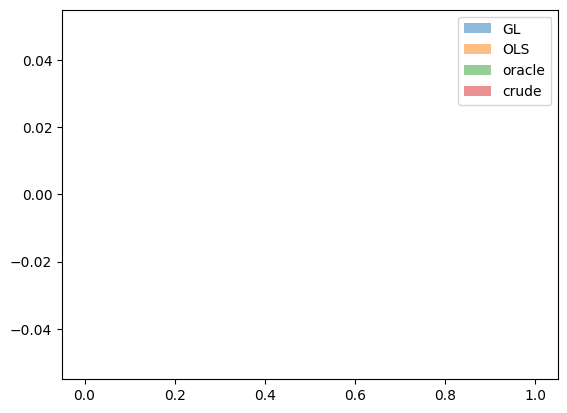

In [45]:
nbins = 25
plt.hist(GL_pe_list,bins=nbins, alpha=0.5, label="GL")
plt.hist(OLS_pe_list,bins=nbins, alpha=0.5, label="OLS")
plt.hist(oracle_pe_list,bins=nbins, alpha=0.5, label="oracle")
plt.hist(crude_pe_list,bins=nbins,alpha=0.5, label="crude")
plt.legend()

In [46]:
np.var(GL_pe_list)

/opt/anaconda3/envs/correlationCorrection/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/correlationCorrection/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/correlationCorrection/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [47]:
np.var(OLS_pe_list)

nan

In [48]:
vb_star

nan

In [49]:
vb

nan

In [50]:
vb_oracle

nan

In [51]:
vb_r

nan

In [52]:
crude_cov[-1]

array([[0.01424189, 0.01273675, 0.01321083],
       [0.01273675, 0.01577181, 0.01344063],
       [0.01321083, 0.01344063, 0.02055278]])

In [53]:
gl_cov[-1]

array([[0.01424189, 0.01338567, 0.01526401],
       [0.01338567, 0.01577181, 0.01598363],
       [0.01526401, 0.01598363, 0.02055278]])

In [54]:
oracle_cov[-1]

array([[0.01424189, 0.0122944 , 0.01232192],
       [0.0122944 , 0.01577181, 0.0124013 ],
       [0.01232192, 0.0124013 , 0.02055278]])

In [55]:
np.mean(crude_cov)

0.013901690389195115

In [56]:
np.mean(crude_cov,axis=0)

array([[0.01382011, 0.01223068, 0.01278087],
       [0.01223068, 0.01506038, 0.01298668],
       [0.01278087, 0.01298668, 0.02023826]])

In [57]:
np.mean(gl_cov,axis=0)

array([[0.01382011, 0.01281033, 0.01483123],
       [0.01281033, 0.01506038, 0.01547025],
       [0.01483123, 0.01547025, 0.02023826]])

In [58]:
np.mean(oracle_cov,axis=0)

array([[0.01382011, 0.01181123, 0.01183469],
       [0.01181123, 0.01506038, 0.01190321],
       [0.01183469, 0.01190321, 0.02023826]])

In [59]:
np.mean(ham_cov,axis=0)

array([[0.01382011, 0.01197598, 0.01197598],
       [0.01197598, 0.01506038, 0.01197598],
       [0.01197598, 0.01197598, 0.02023826]])

In [60]:
np.around(np.mean((np.array(crude_cov) - np.array(oracle_cov)) / (np.array(oracle_cov)), axis=0),3)

array([[-0.   ,  0.036,  0.08 ],
       [ 0.036,  0.   ,  0.091],
       [ 0.08 ,  0.091,  0.   ]])

In [61]:
np.around(np.mean((np.array(gl_cov) - np.array(oracle_cov)) / (np.array(oracle_cov)), axis=0),3)

array([[-0.   ,  0.085,  0.254],
       [ 0.085,  0.   ,  0.3  ],
       [ 0.254,  0.3  ,  0.   ]])

In [65]:
# Not systematic over or underestimating
np.around(np.mean(np.abs(np.array(ham_cov) - np.array(oracle_cov)) / (np.array(oracle_cov)), axis=0),3)

array([[0.   , 0.02 , 0.021],
       [0.02 , 0.   , 0.025],
       [0.021, 0.025, 0.   ]])

In [66]:
np.around(np.mean(np.abs(np.array(gl_cov) - np.array(oracle_cov)) / (np.array(oracle_cov)), axis=0),3)

array([[0.   , 0.085, 0.254],
       [0.085, 0.   , 0.3  ],
       [0.254, 0.3  , 0.   ]])

In [67]:
np.around(np.mean(np.abs(np.array(crude_cov) - np.array(oracle_cov)) / (np.array(oracle_cov)), axis=0),3)

array([[0.   , 0.036, 0.08 ],
       [0.036, 0.   , 0.091],
       [0.08 , 0.091, 0.   ]])